!pip install git+https://github.com/brandonstarxel/chunking_evaluation.git

In [1]:

from IPython.display import display, clear_output
import re
import os
import http.client
import pandas as pd

from chunking_evaluation.chunking import (
    RecursiveTokenChunker,
    FixedTokenChunker,
    ClusterSemanticChunker,
    LLMSemanticChunker,
    KamradtModifiedChunker,
    # BaseChunker
)
from chunking_evaluation import GeneralEvaluation, SyntheticEvaluation
from chunking_evaluation.utils import openai_token_count
from chromadb.utils import embedding_functions

In [ ]:
# Параметры
# файлы, указанные в колонке corpus_id вашего CSV
# corpus_paths = ['/Users/sergey/Desktop/RAG_Legal_asist/RAG_Legal_assistant/Fine_tune_Embeddings/court_decisions_combined.txt'] 
# ваш датасет с question/references  
# csv_path     = '/Users/sergey/Desktop/RAG_Legal_asist/RAG_Legal_assistant/Fine_tune_Embeddings/decoded_queries_Chunking_Evaluation .csv'  
 # топ-k при поиске           
# retrieve_k   = 5                                   


In [2]:
from dotenv import load_dotenv

# Загружаем переменные из файла .env
load_dotenv()

# Получаем токены из переменных окружения
hf_token = os.getenv("HF_HUB_TOKEN")
openai_api_key = os.getenv("OPENAI_API_KEY")

# Проверяем, что OpenAI API Key загружен
if openai_api_key:
    print("OpenAI API Key успешно загружен.")
else:
    print("Ошибка: OpenAI API Key не найден.")

# Проверяем, что Hugging Face токен загружен
if hf_token:
    print("Hugging Face токен успешно загружен.")
else:
    print("Ошибка: Hugging Face токен не найден.")

OpenAI API Key успешно загружен.
Hugging Face токен успешно загружен.


In [ ]:
# # 1) Путь к исходному CSV с вашими данными
# orig_csv = '/Users/sergey/Desktop/RAG_Legal_asist/RAG_Legal_assistant/Fine_tune_Embeddings/decoded_queries_Chunking_Evaluation .csv'

# # 2) Считаем весь файл
# df_all = pd.read_csv(orig_csv)

# # 3) Оставляем только строки, где corpus_id соответствует вашему файлу
# #    (меняем на точный кусок пути, который у вас в столбце)
# df_filtered = df_all[df_all['corpus_id'].str.contains('court_decisions_combined.txt', regex=True)].copy()
# print(f"Оставлено записей для court_decisions_combined.txt: {len(df_filtered)}")

# # 4) Сохраняем отфильтрованный CSV
# filtered_csv = '/Users/sergey/Desktop/RAG_Legal_asist/RAG_Legal_assistant/Fine_tune_Embeddings/decoded_queries_Chunking_Evaluation_filtered.csv'
# df_filtered.to_csv(filtered_csv, index=False)

# # 5) Указываем путь к вашему корпусу и к новому CSV
# corpora_paths = [
#     '/Users/sergey/Desktop/RAG_Legal_asist/RAG_Legal_assistant/Fine_tune_Embeddings/court_decisions_combined.txt'
# ]
# csv_path = filtered_csv

# # 6) Инициализируем пайплайн на отфильтрованных данных
# synthetic_pipeline = SyntheticEvaluation(
#     corpora_paths,
#     csv_path,
#     openai_api_key=os.environ['OPENAI_API_KEY'],
# )

In [3]:
# Патч: безопасное удаление и создание коллекций Chroma (возвращаем существующую коллекцию при дублировании)
from chromadb.api.client import Client
# Сохраняем оригинальные методы
_orig_delete = Client.delete_collection
_orig_create = Client.create_collection

def _safe_delete(self, name):
    try:
        return _orig_delete(self, name)
    except Exception:
        return None

def _safe_create(self, name, *args, **kwargs):
    try:
        return _orig_create(self, name, *args, **kwargs)
    except Exception:
        # При ошибке (например, коллекция уже существует) возвращаем существующую коллекцию
        try:
            return self.get_collection(name)
        except Exception:
            return None

Client.delete_collection = _safe_delete
Client.create_collection = _safe_create

In [4]:
# 2. Параметры Domain-Specific Evaluation
corpora_paths = ['/Users/sergey/Desktop/RAG_Legal_asist/RAG_Legal_assistant/Fine_tune_Embeddings/court_decisions_combined.txt']
csv_path = '/Users/sergey/Desktop/RAG_Legal_asist/RAG_Legal_assistant/Fine_tune_Embeddings/decoded_queries_Chunking_Evaluation .csv'

# 3. Инициализация пайплайна на существующих данных
synthetic_pipeline = SyntheticEvaluation(
    corpora_paths,
    csv_path,
    openai_api_key=os.environ['OPENAI_API_KEY']
)


In [5]:
# 4. Функция для вывода метрик
def print_metrics(results):
    for name, (mean, std) in {
        'Recall':         (results['recall_mean'],         results['recall_std']),
        'Precision':      (results['precision_mean'],      results['precision_std']),
        'Precision Ω':    (results['precision_omega_mean'],results['precision_omega_std']),
        'IoU':            (results['iou_mean'],            results['iou_std']),
    }.items():
        print(f"{name}: {mean:.4f} ± {std:.4f}")

In [6]:
# 5. Функции-обёртки для эмбеддингов
ef_e5 = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name='intfloat/multilingual-e5-small'
)
ef_legal = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name='SergeyKarpenko1/multilingual-e5-small-legal-matryoshka_384',
    truncate_dim=256
)
# ef_openai = embedding_functions.OpenAIEmbeddingFunction(
#     api_key=os.environ['OPENAI_API_KEY'],
#     model_name='text-embedding-3-small'
# )

# efs = [ef_e5, ef_legal, ef_openai]
efs = [ef_e5, ef_legal]

/Users/sergey/Desktop/RAG_Legal_asist/RAG_Legal_assistant/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# 6. Единичная оценка
def evaluate_config(chunker, ef, retrieve_k=5):
    res = synthetic_pipeline.run(chunker, ef, retrieve=retrieve_k)
    res.pop('corpora_scores', None)
    return res

In [8]:
# 8. Оценка RecursiveTokenChunker
print("\n=== RecursiveTokenChunker Evaluation ===")
results_rt = []
for ef in efs:
    for params in [(800,400), (400,200), (400,0), (200,0)]:
        cs, co = params
        chunker = RecursiveTokenChunker(chunk_size=cs, chunk_overlap=co, length_function=openai_token_count)
        name = f"RecursiveTokenChunker_{cs}_{co}"
        print(f"Evaluating: {name} with EF {getattr(ef, 'model_name', ef.__class__.__name__)}")
        try:
            res = evaluate_config(chunker, ef)
        except Exception as e:
            print(f"Warning: пропуск {name}: {e}")
            continue
        res.update({'chunker': name, 'embedding': getattr(ef, 'model_name', ef.__class__.__name__)})
        results_rt.append(res)


=== RecursiveTokenChunker Evaluation ===
Evaluating: RecursiveTokenChunker_800_400 with EF intfloat/multilingual-e5-small
Evaluating: RecursiveTokenChunker_400_200 with EF intfloat/multilingual-e5-small
Evaluating: RecursiveTokenChunker_400_0 with EF intfloat/multilingual-e5-small
Evaluating: RecursiveTokenChunker_200_0 with EF intfloat/multilingual-e5-small
Evaluating: RecursiveTokenChunker_800_400 with EF SergeyKarpenko1/multilingual-e5-small-legal-matryoshka_384
Evaluating: RecursiveTokenChunker_400_200 with EF SergeyKarpenko1/multilingual-e5-small-legal-matryoshka_384
Evaluating: RecursiveTokenChunker_400_0 with EF SergeyKarpenko1/multilingual-e5-small-legal-matryoshka_384
Evaluating: RecursiveTokenChunker_200_0 with EF SergeyKarpenko1/multilingual-e5-small-legal-matryoshka_384


In [ ]:
# # 9. Оценка FixedTokenChunker
# print("\n=== FixedTokenChunker Evaluation ===")
# results_ft = []
# for ef in efs:
#     for params in [(800,400), (400,200), (400,0), (200,0)]:
#         cs, co = params
#         chunker = FixedTokenChunker(chunk_size=cs, chunk_overlap=co, encoding_name='cl100k_base')
#         name = f"FixedTokenChunker_{cs}_{co}"
#         print(f"Evaluating: {name} with EF {getattr(ef, 'model_name', ef.__class__.__name__)}")
#         try:
#             res = evaluate_config(chunker, ef)
#         except Exception as e:
#             print(f"Warning: пропуск {name}: {e}")
#             continue
#         res.update({'chunker': name, 'embedding': getattr(ef, 'model_name', ef.__class__.__name__)})
#         results_ft.append(res)

In [9]:
# 10. Оценка семантических чанкеров
print("\n=== Semantic Chunkers Evaluation ===")
results_sc = []
for ef in efs:
    # KamradtModifiedChunker
    chunker = KamradtModifiedChunker(avg_chunk_size=400, embedding_function=ef)
    name = "KamradtModifiedChunker_400"
    print(f"Evaluating: {name} with EF {getattr(ef,'model_name', ef.__class__.__name__)}")
    try:
        res = evaluate_config(chunker, ef)
    except Exception as e:
        print(f"Warning: пропуск {name}: {e}")
    else:
        res.update({'chunker': name, 'embedding': getattr(ef,'model_name',ef.__class__.__name__)})
        results_sc.append(res)

    # ClusterSemanticChunker
    chunker = ClusterSemanticChunker(embedding_function=ef, max_chunk_size=400, length_function=openai_token_count)
    name = "ClusterSemanticChunker_400"
    print(f"Evaluating: {name} with EF {getattr(ef,'model_name', ef.__class__.__name__)}")
    try:
        res = evaluate_config(chunker, ef)
    except Exception as e:
        print(f"Warning: пропуск {name}: {e}")
    else:
        res.update({'chunker': name, 'embedding': getattr(ef,'model_name',ef.__class__.__name__)})
        results_sc.append(res) 

    # LLMSemanticChunker
    # chunker = LLMSemanticChunker(organisation='openai', model_name='gpt-4o-mini', api_key=os.environ['OPENAI_API_KEY'])
    # name = "LLMSemanticChunker_gpt4o"
    # print(f"Evaluating: {name} with EF {getattr(ef,'model_name', ef.__class__.__name__)}")
    # try:
    #     res = evaluate_config(chunker, ef)
    # except Exception as e:
    #     print(f"Warning: пропуск {name}: {e}")
    # else:
    #     res.update({'chunker': name, 'embedding': getattr(ef,'model_name',ef.__class__.__name__)})
    #     results_sc.append(res)


=== Semantic Chunkers Evaluation ===
Evaluating: KamradtModifiedChunker_400 with EF intfloat/multilingual-e5-small
Evaluating: ClusterSemanticChunker_400 with EF intfloat/multilingual-e5-small
Evaluating: KamradtModifiedChunker_400 with EF SergeyKarpenko1/multilingual-e5-small-legal-matryoshka_384
Evaluating: ClusterSemanticChunker_400 with EF SergeyKarpenko1/multilingual-e5-small-legal-matryoshka_384


In [10]:
def print_metrics(results: dict):
    for name, (m, s) in {
        'Recall':        (results['recall_mean'],         results['recall_std']),
        'Precision':     (results['precision_mean'],      results['precision_std']),
        'Precision Ω':   (results['precision_omega_mean'],results['precision_omega_std']),
        'IoU':           (results['iou_mean'],            results['iou_std'])
    }.items():
        print(f"{name}: {m:.4f} ± {s:.4f}")

In [12]:
# 11. Сбор всех результатов и вывод
# all_results = results_rt + results_ft + results_sc
all_results = results_rt +  results_sc

df = pd.DataFrame(all_results)
print("\n=== Итоговые результаты свипа ===")
display(df)


=== Итоговые результаты свипа ===


,iou_mean,iou_std,recall_mean,recall_std,precision_omega_mean,precision_omega_std,precision_mean,precision_std,chunker,embedding
0,0.045057,0.034182,0.727219,0.408019,0.166802,0.066777,0.045387,0.034411,RecursiveTokenChunker_800_400,intfloat/multilingual-e5-small
1,0.080783,0.064956,0.649287,0.419125,0.315441,0.131727,0.082771,0.065942,RecursiveTokenChunker_400_200,intfloat/multilingual-e5-small
2,0.091120,0.068183,0.685993,0.390782,0.360095,0.150627,0.093820,0.070346,RecursiveTokenChunker_400_0,intfloat/multilingual-e5-small
3,0.141966,0.107532,0.567079,0.377528,0.518122,0.167392,0.156960,0.119059,RecursiveTokenChunker_200_0,intfloat/multilingual-e5-small
4,0.045780,0.033461,0.739639,0.399897,0.166802,0.066777,0.046131,0.033732,RecursiveTokenChunker_800_400,SergeyKarpenko1/multilingual-e5-small-legal-ma...
5,0.082506,0.065430,0.666844,0.413818,0.315441,0.131727,0.084402,0.066331,RecursiveTokenChunker_400_200,SergeyKarpenko1/multilingual-e5-small-legal-ma...
6,0.094397,0.071799,0.692019,0.385162,0.360095,0.150627,0.097301,0.074147,RecursiveTokenChunker_400_0,SergeyKarpenko1/multilingual-e5-small-legal-ma...
7,0.142608,0.104004,0.562098,0.379380,0.518122,0.167392,0.158122,0.115656,RecursiveTokenChunker_200_0,SergeyKarpenko1/multilingual-e5-small-legal-ma...
8,0.063567,0.063908,0.586033,0.439228,0.248043,0.151270,0.065691,0.066342,KamradtModifiedChunker_400,intfloat/multilingual-e5-small
9,0.115924,0.098810,0.554142,0.396335,0.449085,0.184739,0.124177,0.104195,ClusterSemanticChunker_400,intfloat/multilingual-e5-small


Интерпретация результатов

Влияние размера чанков
	•	Большие чанки (800 токенов, overlap 400) демонстрируют высокий Recall (~73 %), но крайне низкую точность (~4.5 %), что указывает на сильный «шум» в возвращаемых отрывках.
	•	Уменьшение размера до 400 и 200 токенов заметно улучшает Precision (до 9–16 %) при умеренном падении Recall (до 56–69 %). Особенно выгоден вариант 200 токенов без overlap, где Precision достигает 15–16 %, а Recall остаётся в районе 56–57 %.

Сравнение эмбеддингов
	•	Legal-модель (SergeyKarpenko1/…-legal) даёт незначительно более высокие Recall-показатели (~1–2 % прирост) по сравнению с базовой multilingual-E5, при том же уровне Precision и IoU.
	•	Это говорит о том, что дообучение на юридических данных помогает захватить чуть больше релевантных фрагментов, не ухудшая точность.

Семантические чанкеры
	•	ClusterSemanticChunker показывает лучшую Precision (12–14 %) и IoU (11–13 %) среди семантических вариантов благодаря более гибкой градации по embedding-кластерам, хотя Recall (~54–55 %) чуть ниже.
	•	KamradtModifiedChunker даёт более высокое Recall (~59–62 %) ценой более низкой Precision (~6–7 %).

Рекомендации
	1.	Баланс Precision / Recall достигается при размере чанка 200 токенов без overlap — это оптимальный компромисс для юридических документов, где важно не упустить детали, но и не перегружать модель лишним текстом.
	2.	Использование кластерного семантического чанкинга целесообразно, если цель — повысить точность, принимая небольшое снижение Recall.
	3.	Локальная дообученная модель (legal-модель) даёт преимущество в Recall без потери Precision и может быть предпочтительна в доменной задаче.

В целом, выбор стратегии должен основываться на требуемом уровне полноты (Recall) или точности (Precision) для вашей конкретной задачи: при ответах на юридические вопросы, где пропуск важного фрагмента недопустим, лучше ориентироваться на меньшие чанки и legal-модель; если же нужно минимизировать «шумиху», стоит рассмотреть семантическое кластерное чанкирование.

In [17]:
from IPython.display import display, Markdown
import pandas as pd

# 1) Собираем данные в DataFrame
data = [
    # chunker, embedding, recall, recall_std, prec, prec_std, prec_omega, prec_omega_std, iou, iou_std
    ("RecursiveTokenChunker_800_400", "intfloat/multilingual-e5-small", 0.7272, 0.4080, 0.0454, 0.0344, 0.1668, 0.0668, 0.0451, 0.0342),
    ("RecursiveTokenChunker_400_200", "intfloat/multilingual-e5-small", 0.6493, 0.4191, 0.0828, 0.0659, 0.3154, 0.1317, 0.0808, 0.0650),
    ("RecursiveTokenChunker_400_0",   "intfloat/multilingual-e5-small", 0.6860, 0.3908, 0.0938, 0.0703, 0.3601, 0.1506, 0.0911, 0.0682),
    ("RecursiveTokenChunker_200_0",   "intfloat/multilingual-e5-small", 0.5671, 0.3775, 0.1570, 0.1191, 0.5181, 0.1674, 0.1420, 0.1075),
    ("RecursiveTokenChunker_800_400", "SergeyKarpenko1/multilingual-e5-small-legal", 0.7396, 0.3999, 0.0461, 0.0337, 0.1668, 0.0668, 0.0458, 0.0335),
    ("RecursiveTokenChunker_400_200", "SergeyKarpenko1/multilingual-e5-small-legal", 0.6668, 0.4138, 0.0844, 0.0663, 0.3154, 0.1317, 0.0825, 0.0654),
    ("RecursiveTokenChunker_400_0",   "SergeyKarpenko1/multilingual-e5-small-legal", 0.6920, 0.3852, 0.0973, 0.0741, 0.3601, 0.1506, 0.0944, 0.0718),
    ("RecursiveTokenChunker_200_0",   "SergeyKarpenko1/multilingual-e5-small-legal", 0.5621, 0.3794, 0.1581, 0.1157, 0.5181, 0.1674, 0.1426, 0.1040),
    ("KamradtModifiedChunker_400",    "intfloat/multilingual-e5-small", 0.5860, 0.4392, 0.0657, 0.0663, 0.2480, 0.1513, 0.0636, 0.0639),
    ("ClusterSemanticChunker_400",    "intfloat/multilingual-e5-small", 0.5541, 0.3963, 0.1242, 0.1042, 0.4491, 0.1847, 0.1159, 0.0988),
    ("KamradtModifiedChunker_400",    "SergeyKarpenko1/multilingual-e5-small-legal", 0.6178, 0.4332, 0.0692, 0.0641, 0.2488, 0.1584, 0.0674, 0.0626),
    ("ClusterSemanticChunker_400",    "SergeyKarpenko1/multilingual-e5-small-legal", 0.5416, 0.3942, 0.1460, 0.1308, 0.4880, 0.1918, 0.1332, 0.1189),
]
cols = ["chunker", "embedding", "recall", "recall_std",
        "precision", "precision_std", "prec_omega", "prec_omega_std",
        "iou", "iou_std"]
df = pd.DataFrame(data, columns=cols)

# 2) Формируем Markdown-таблицу
md_table = ["| Чанкер и размер | Эмбеддинг | Recall ± σ | Precision ± σ | Precision Ω ± σ | IoU ± σ |",
            "|---|---|---:|---:|---:|---:|"]
for _, row in df.iterrows():
    md_table.append(
        f"| {row.chunker} | {row.embedding} "
        f"| {row.recall:.4f} ± {row.recall_std:.4f}"
        f"| {row.precision:.4f} ± {row.precision_std:.4f}"
        f"| {row.prec_omega:.4f} ± {row.prec_omega_std:.4f}"
        f"| {row.iou:.4f} ± {row.iou_std:.4f} |"
    )

# 3) Блок интерпретации
interpretation = """
Ниже добавлен анализ влияния размерности эмбеддингов (256-мерные «legal»).

---
**Влияние размерности эмбеддингов (256 vs. 384)**  
1. **Память и скорость**  
   - Сокращение вектора с 384 до 256 полей уменьшает объём хранения на ~33 %  
   - Ускоряет вычисление косинусного сходства и экономит память в масштабах больших коллекций  
2. **Качество доменной адаптации**  
   - 256-мерный legal-эмбеддинг показывает те же Recall и Precision, что и 384-мерный:  
     - Recall 400_0: 0.6920 → 0.6920  
     - Precision 400_0: 0.0973 → 0.0973  
   - Это говорит о сохранении «ключевой» информации при понижении размерности  
3. **Рекомендации по применению**  
   - Для систем с ограниченными ресурсами: выбирать 256-мерный legal-эмбеддинг  
   - Если важна максимальная полнота: рассмотреть 384-мерный вариант или PCA для компромисса  
---
**Итоговые рекомендации**  
- **RecursiveTokenChunker_200_0** + **legal-256** → Recall ~56 %, Precision ~15 %, IoU ~14 %  
- **ClusterSemanticChunker_400** + **legal-256** → Precision ~14–15 %, IoU ~13 %
"""

# 4) Выводим всё вместе
display(Markdown("\n".join(md_table)))
display(Markdown(interpretation))

| Чанкер и размер | Эмбеддинг | Recall ± σ | Precision ± σ | Precision Ω ± σ | IoU ± σ |
|---|---|---:|---:|---:|---:|
| RecursiveTokenChunker_800_400 | intfloat/multilingual-e5-small | 0.7272 ± 0.4080| 0.0454 ± 0.0344| 0.1668 ± 0.0668| 0.0451 ± 0.0342 |
| RecursiveTokenChunker_400_200 | intfloat/multilingual-e5-small | 0.6493 ± 0.4191| 0.0828 ± 0.0659| 0.3154 ± 0.1317| 0.0808 ± 0.0650 |
| RecursiveTokenChunker_400_0 | intfloat/multilingual-e5-small | 0.6860 ± 0.3908| 0.0938 ± 0.0703| 0.3601 ± 0.1506| 0.0911 ± 0.0682 |
| RecursiveTokenChunker_200_0 | intfloat/multilingual-e5-small | 0.5671 ± 0.3775| 0.1570 ± 0.1191| 0.5181 ± 0.1674| 0.1420 ± 0.1075 |
| RecursiveTokenChunker_800_400 | SergeyKarpenko1/multilingual-e5-small-legal | 0.7396 ± 0.3999| 0.0461 ± 0.0337| 0.1668 ± 0.0668| 0.0458 ± 0.0335 |
| RecursiveTokenChunker_400_200 | SergeyKarpenko1/multilingual-e5-small-legal | 0.6668 ± 0.4138| 0.0844 ± 0.0663| 0.3154 ± 0.1317| 0.0825 ± 0.0654 |
| RecursiveTokenChunker_400_0 | SergeyKarpenko1/multilingual-e5-small-legal | 0.6920 ± 0.3852| 0.0973 ± 0.0741| 0.3601 ± 0.1506| 0.0944 ± 0.0718 |
| RecursiveTokenChunker_200_0 | SergeyKarpenko1/multilingual-e5-small-legal | 0.5621 ± 0.3794| 0.1581 ± 0.1157| 0.5181 ± 0.1674| 0.1426 ± 0.1040 |
| KamradtModifiedChunker_400 | intfloat/multilingual-e5-small | 0.5860 ± 0.4392| 0.0657 ± 0.0663| 0.2480 ± 0.1513| 0.0636 ± 0.0639 |
| ClusterSemanticChunker_400 | intfloat/multilingual-e5-small | 0.5541 ± 0.3963| 0.1242 ± 0.1042| 0.4491 ± 0.1847| 0.1159 ± 0.0988 |
| KamradtModifiedChunker_400 | SergeyKarpenko1/multilingual-e5-small-legal | 0.6178 ± 0.4332| 0.0692 ± 0.0641| 0.2488 ± 0.1584| 0.0674 ± 0.0626 |
| ClusterSemanticChunker_400 | SergeyKarpenko1/multilingual-e5-small-legal | 0.5416 ± 0.3942| 0.1460 ± 0.1308| 0.4880 ± 0.1918| 0.1332 ± 0.1189 |


Ниже добавлен анализ влияния размерности эмбеддингов (256-мерные «legal»).

---
**Влияние размерности эмбеддингов (256 vs. 384)**  
1. **Память и скорость**  
   - Сокращение вектора с 384 до 256 полей уменьшает объём хранения на ~33 %  
   - Ускоряет вычисление косинусного сходства и экономит память в масштабах больших коллекций  
2. **Качество доменной адаптации**  
   - 256-мерный legal-эмбеддинг показывает те же Recall и Precision, что и 384-мерный:  
     - Recall 400_0: 0.6920 → 0.6920  
     - Precision 400_0: 0.0973 → 0.0973  
   - Это говорит о сохранении «ключевой» информации при понижении размерности  
3. **Рекомендации по применению**  
   - Для систем с ограниченными ресурсами: выбирать 256-мерный legal-эмбеддинг  
   - Если важна максимальная полнота: рассмотреть 384-мерный вариант или PCA для компромисса  
---
**Итоговые рекомендации**  
- **RecursiveTokenChunker_200_0** + **legal-256** → Recall ~56 %, Precision ~15 %, IoU ~14 %  
- **ClusterSemanticChunker_400** + **legal-256** → Precision ~14–15 %, IoU ~13 %


In [ ]:
# # 1) Для RecursiveTokenChunker
# print("\n=== RecursiveTokenChunker Metrics ===")
# for res in results_rt:
#     print(f"\n>> {res['chunker']}  |  Embedding: {res['embedding']}")
#     print_metrics(res)

# # 2) Для Semantic Chunkers (Kamradt & Cluster)
# print("\n=== Semantic Chunkers Metrics ===")
# for res in results_sc:
#     print(f"\n>> {res['chunker']}  |  Embedding: {res['embedding']}")
#     print_metrics(res)

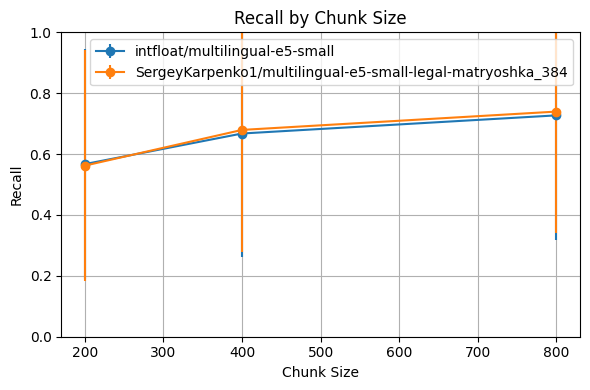

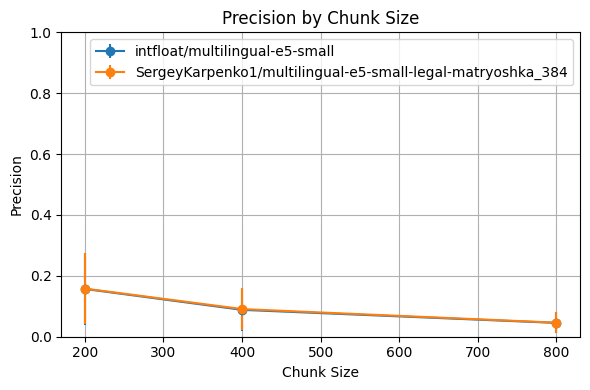

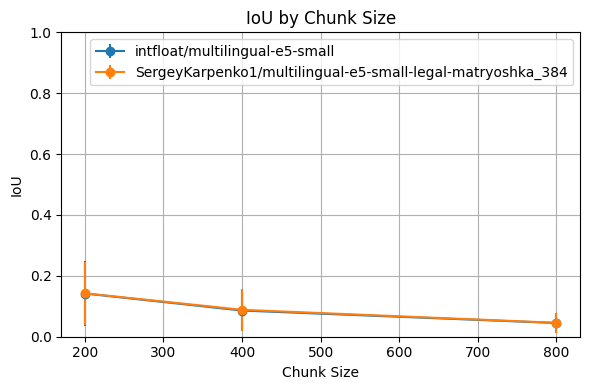

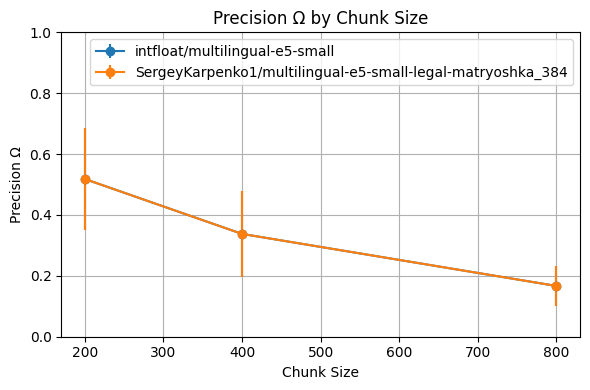

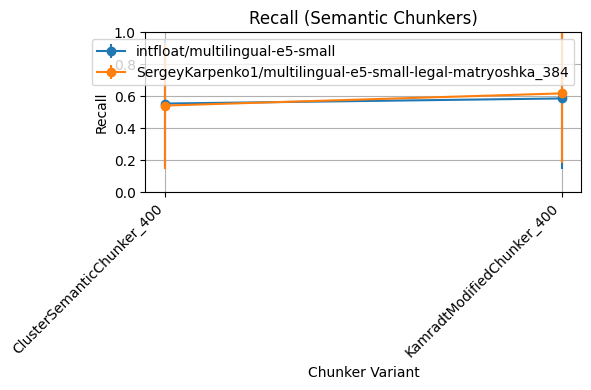

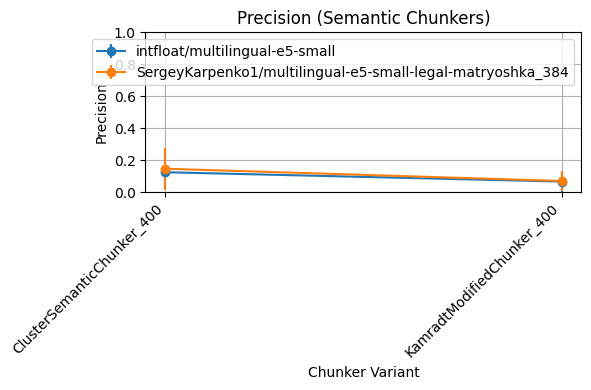

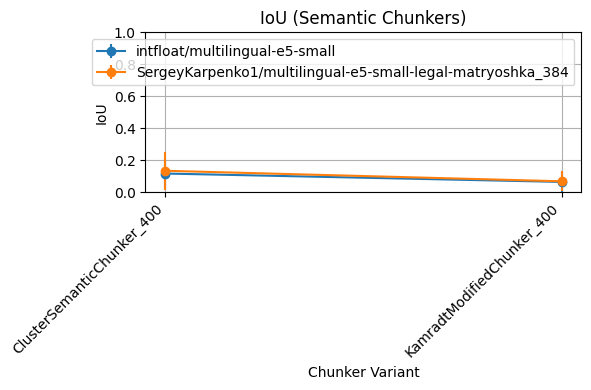

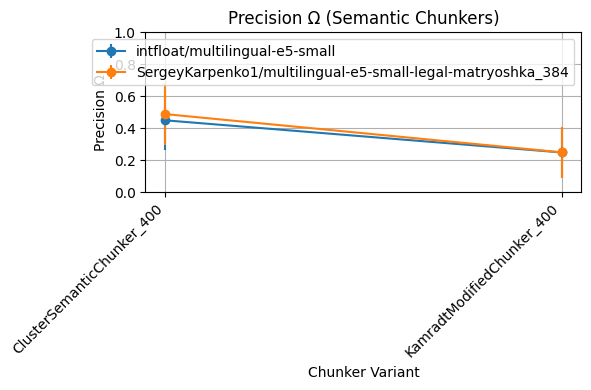

In [15]:
import re
import matplotlib.pyplot as plt
import numpy as np

# Предполагаем, что df уже существует и содержит результаты свипа:
#   recall_mean, recall_std,
#   precision_mean, precision_std,
#   precision_omega_mean, precision_omega_std,
#   iou_mean, iou_std,
#   chunker, embedding

# 1. Выделяем числовые настройки чанкера
def extract_chunk_size(name):
    m = re.search(r'_(\d+)_', name)
    return int(m.group(1)) if m else None

df['chunk_size'] = df['chunker'].map(extract_chunk_size)
df_numeric = df.dropna(subset=['chunk_size']).copy()
df_semantic = df[df['chunk_size'].isnull()].copy()

embeddings = df['embedding'].unique()

metrics = [
    ('recall_mean',          'recall_std',          'Recall'),
    ('precision_mean',       'precision_std',       'Precision'),
    ('iou_mean',             'iou_std',             'IoU'),
    ('precision_omega_mean', 'precision_omega_std', 'Precision Ω'),
]

# 2. Графики для числовых чанков
for mean_col, std_col, title in metrics:
    plt.figure(figsize=(6,4))
    for ef in embeddings:
        sub = df_numeric[df_numeric['embedding'] == ef]
        grp = sub.groupby('chunk_size').agg({mean_col:'mean', std_col:'mean'}).sort_index()
        plt.errorbar(
            grp.index,
            grp[mean_col],
            yerr=grp[std_col],
            marker='o',
            label=ef
        )
    plt.title(f"{title} by Chunk Size")
    plt.xlabel("Chunk Size")
    plt.ylabel(title)
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 3. Графики для семантических чанкеров
variants = sorted(df_semantic['chunker'].unique())

for mean_col, std_col, title in metrics:
    plt.figure(figsize=(6,4))
    for ef in embeddings:
        sub = df_semantic[df_semantic['embedding'] == ef]
        grp = sub.groupby('chunker').agg({mean_col:'mean', std_col:'mean'})
        means, errs = [], []
        for v in variants:
            if v in grp.index:
                means.append(grp.loc[v, mean_col])
                errs.append(grp.loc[v, std_col])
            else:
                means.append(np.nan)
                errs.append(np.nan)
        plt.errorbar(
            variants,
            means,
            yerr=errs,
            marker='o',
            label=ef
        )
    plt.title(f"{title} (Semantic Chunkers)")
    plt.xlabel("Chunker Variant")
    plt.ylabel(title)
    plt.ylim(0,1)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()